In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from collections import Counter
from evaluate import f1score

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10, 6)

In [2]:
#
#
# This script takes a stab at establishing a baseline prediction. We will make the
# most naive model we can think of, and then systematically tear apart its underlying
# assumptions until we have a model that actually works ;).
#
# The idea is simple: given a customer, predict that his/her next basket will contain
# all products which ... 
#  (i) appear in > 80% of his/her previous baskets, or
#  (ii) appear more than once in his/her previous baskets, or
#  (iii) appear at all in any previous baskets
#
# We will test these three ideas on the training set, and submit the one which gives 
# the best F1 score.
#
#

In [11]:
#
# Load prior data from the "train" set
#

print "Reading prior orders data from train set ... ",
prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')

# down-select to only those users appearing in the training set
uids = orders[orders['eval_set'] == 'train']['user_id'].unique()
prior = prior.merge(orders, on='order_id', how='left')
prior = prior[prior['user_id'].isin(uids)]

print "done."

Reading prior orders data from train set ...  done.


In [15]:
#
# Load the training data for evaluating the predictive models
#

# Load the training data mapping order_id to the products ordered
def products_reordered(x):
    # The "correct" answer: the set of all products that were previously ordered
    # and appear in the customer's next basket.
    # NB: there should only be one order per user in the training set and set() vs
    # list() shouldn't matter. This is a worth a sanity check CHECKME.
    return set(x[x['reordered'] == 1]['product_id'])

train = pd.read_csv('order_products__train.csv').merge(orders, on='order_id', how='left')
train_set = train.groupby('user_id').apply(
    products_reordered).reset_index(name='products_reordered')
train_set.head()

,user_id,products_reordered
0,1,"{196, 26405, 13032, 39657, 25133, 38928, 26088..."
1,2,"{41787, 33957, 22825, 45066, 16589, 45613, 229..."
2,5,"{21616, 40706, 15349, 21413}"
3,7,"{29894, 17638, 47272, 45066, 13198, 37999, 408..."
4,8,"{15937, 41540, 23165, 21903}"


0.0665053385185


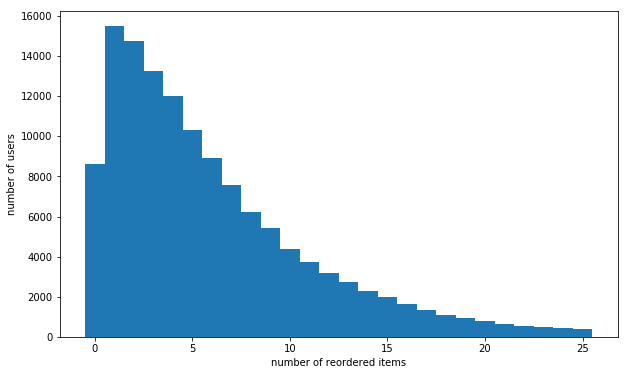

0.0978002541931


In [17]:
#
# A quick aside on some interesting features of the training data
#

# 93% of users reorder at least one item
t = train.groupby('order_id').apply(lambda x: sum(x['reordered']))
n, bins, patches = plt.hist(t, bins=np.linspace(-0.5, 25.5, 27))
print n[0] / 1.0 / sum(n)
plt.xlabel('number of reordered items')
plt.ylabel('number of users')
plt.show()

# but only 10% of products are reordered
t = prior.groupby('user_id').apply(lambda x: len(set(x['product_id']))).sum()
s = train['reordered'].sum()
print s / 1.0 / t

In [20]:
# some heuristic models for making predictions of future reorders
# no ML yet!! just establishing a baseline
def products_p(x, prob):
    C = Counter(x['product_id'])
    norders = len(set(x['order_id']))
    return set([p for p in C if C[p] / float(norders) > prob])

def products_n(x, n):
    C = Counter(x['product_id'])
    norders = len(set(x['order_id']))
    return set([p for p in C if C[p] > n])

for p in [0.2, 0.5, 0.8]:
    print "p model", p, "...",
    heuristic = lambda x: products_p(x, p)
    predict = prior.groupby(['user_id']).apply(heuristic)
    predict = predict.reset_index(name='products_predicted')
    print "F1:", f1score(predict['products_predicted'], train_set['products_reordered'])
    
for n in [0, 1, 2, 3]:
    print "n model", n, "...",
    heuristic = lambda x: products_n(x, n)
    predict = prior.groupby(['user_id']).apply(heuristic)
    predict = predict.reset_index(name='products_predicted')
    print "F1:", f1score(predict['products_predicted'], train_set['products_reordered'])

 p model 0.2 ... F1: 0.321563249758
p model 0.5 ... F1: 0.265367442142
p model 0.8 ... F1: 0.14699473447
n model 0 ... F1: 0.215400579483
n model 1 ... F1: 0.302637573062
n model 2 ... F1: 0.307927178382
n model 3 ... F1: 0.276981840147


In [28]:
#
# Let's submit the winning score. 
#

#
# First, generate "features" for users from the "test" data set.
#

print "Reading prior orders data from test set ... ",
prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')

# down-select to only those users appearing in the training set
uids = orders[orders['eval_set'] == 'test']['user_id'].unique()
prior = prior.merge(orders, on='order_id', how='left')
prior = prior[prior['user_id'].isin(uids)]

print "done."

Reading prior orders data from test set ...  done.


In [41]:
#
# Compute features and predictions from the winning model
#

winner = lambda x: products_n(x, 2)
#
# The first time through, this was the winner. But later I suspected
# (and turned out to be correct) that p = 0.2 was a good threshold. Since
# the n = 2 model is what I ended up submitting, I leave this "losing"
# model as the winner here.
#

predict = prior.groupby(['user_id']).apply(winner).reset_index(name='products_predicted')
predict = predict.merge(orders[orders['eval_set'] == 'test'],
    on='user_id', how='left')[['order_id', 'products_predicted']]
predict.head()

,order_id,products_predicted
0,2774568,"{17668, 39190, 18599, 24810, 9387, 21903, 3240..."
1,329954,{}
2,1528013,{}
3,1376945,"{34658, 14947, 35948, 28465, 8309, 27959, 3564..."
4,1356845,"{14992, 13176, 7076, 10863}"


In [42]:
#
# write out predictions for submission
#

fd = open('submission.csv', 'w')
fd.write('order_id,products\n')

for oid, pr in zip(predict['order_id'], predict['products_predicted']):
    fd.write('%d,' % oid)

    if pr:
        fd.write(' '.join(map(str, pr)))
    else:
        fd.write('None')
    fd.write('\n')

fd.close()